In [1]:
from src import *

## Table of Contents
We check whether there are periods of time where across subjects the respective individuals gradients behave very similarly, we can then look at the corresponding video as well.
- [Synchrony of metrics across individual gradients](#synchro)

<a class="anchor" id="synchro"></a>
### Synchrony of metrics across individual gradients
We look at some small enough periods and do cross correlation for subjcets and see what appears most often.

In [42]:
# Loading Gradient Example
networks  = list(index2region.keys())
moviename = 'Sintel'
tmp = load('./resources/dynamic_grad/individual_level/Sintel_40_grad.pkl')

G_movie, varM = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))
# Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

We would be interested in some examples found in notebook 7:
- Sad/Dor/Metric 3
- Anger/Dor/Metric 3

In [64]:
geny  = np.asarray([network_volume(G_movie[t], networks[2]) 
                for t in range(len(G_movie))])
geny = zscore(geny)

In [43]:
subj_grads = np.asarray([tmp[s][0] for s in tmp])

In [44]:
subjects = list(tmp.keys())
networks = list(index2region.keys())
indiv_metrics = np.zeros((len(subjects), len(networks), subj_grads.shape[1]))
for s in range(len(subjects)):
    for n in range(len(networks)):
        G_tmp = subj_grads[s]
        y  = np.asarray([network_volume(G_tmp[t], networks[n]) 
                        for t in range(len(G_tmp))])
        z1 = zscore(y)
        indiv_metrics[s,n] = z1
        # indiv_metric[s] = y / y.mean()

In [83]:
sws = 15
T = indiv_metrics.shape[-1]
tmp = []
for n in range(len(networks)):
    local_cross_correlation = np.zeros((T//sws, indiv_metrics.shape[0], indiv_metrics.shape[0]))
    smoothed = [low_pass(a, ks=20)  for a in indiv_metrics[:,n]]
    smoothed = np.asarray(smoothed)

    for idx,s in enumerate(range(0,T,sws)):

        cur_time = smoothed[:,s:s+sws]
        if cur_time.shape[-1] != sws: continue
        corr = FC(cur_time.T)
        local_cross_correlation[idx] = corr

    tmp.append(np.mean(local_cross_correlation - np.eye(30), axis=(1,2)))
tmp = np.asarray(tmp)

In [59]:
emo_series = np.array(emo_df[emo_df.item=='Anger']['score'])
smoothened = overlap_add(emo_series, 1)
ye   = zscore(smoothened[:tmp.shape[0]])

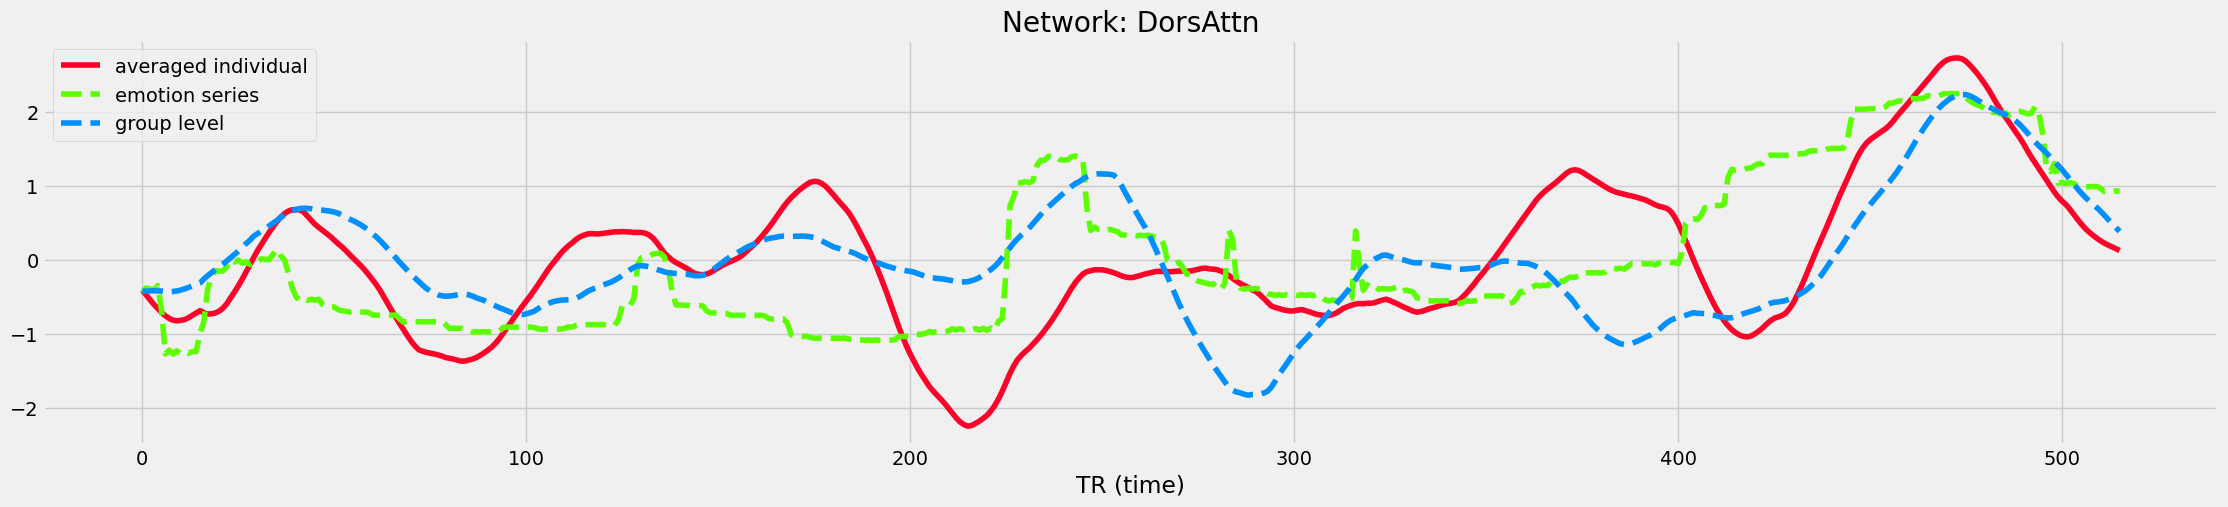

In [75]:
NUM_COLORS = 3
fig, ax = plt.subplots(1, figsize=(25,5))
cm = plt.get_cmap('gist_rainbow')

ax.set_prop_cycle(color=[cm(1.*k/NUM_COLORS) for k in range(NUM_COLORS)])

tmp = indiv_metrics[:,2].mean(axis=0)
tmp = zscore(low_pass(tmp, ks=30))
ax.plot(-tmp, label='averaged individual')
ax.set_title('Network: {}'.format(networks[2]))
ax.set_xlabel('TR (time)')

ax.plot(ye, linestyle='--', label='emotion series')
ax.plot(-low_pass(geny, ks=30), linestyle='--', label='group level')
ax.legend()

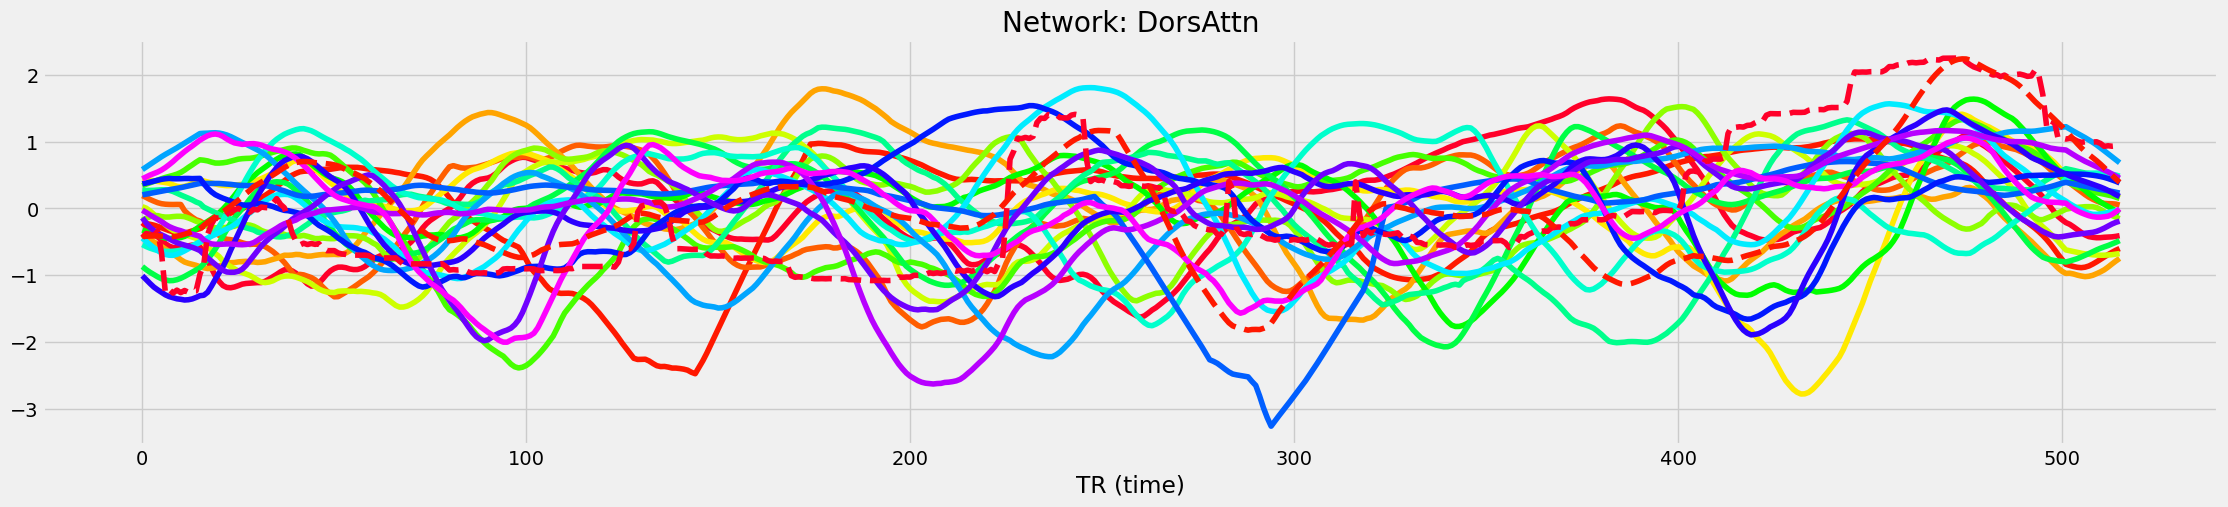

In [69]:
NUM_COLORS = len(subjects) - 10
fig, ax = plt.subplots(1, figsize=(25,5))
cm = plt.get_cmap('gist_rainbow')

ax.set_prop_cycle(color=[cm(1.*k/NUM_COLORS) for k in range(NUM_COLORS)])
for s in range(len(subjects)-10):
    tmp = indiv_metrics[s][2]
    tmp = low_pass(tmp, ks=30)
    ax.plot(-tmp)
    ax.set_title('Network: {}'.format(networks[2]))
    ax.set_xlabel('TR (time)')

ax.plot(ye, linestyle='--')
ax.plot(-low_pass(geny, ks=30), linestyle='--')

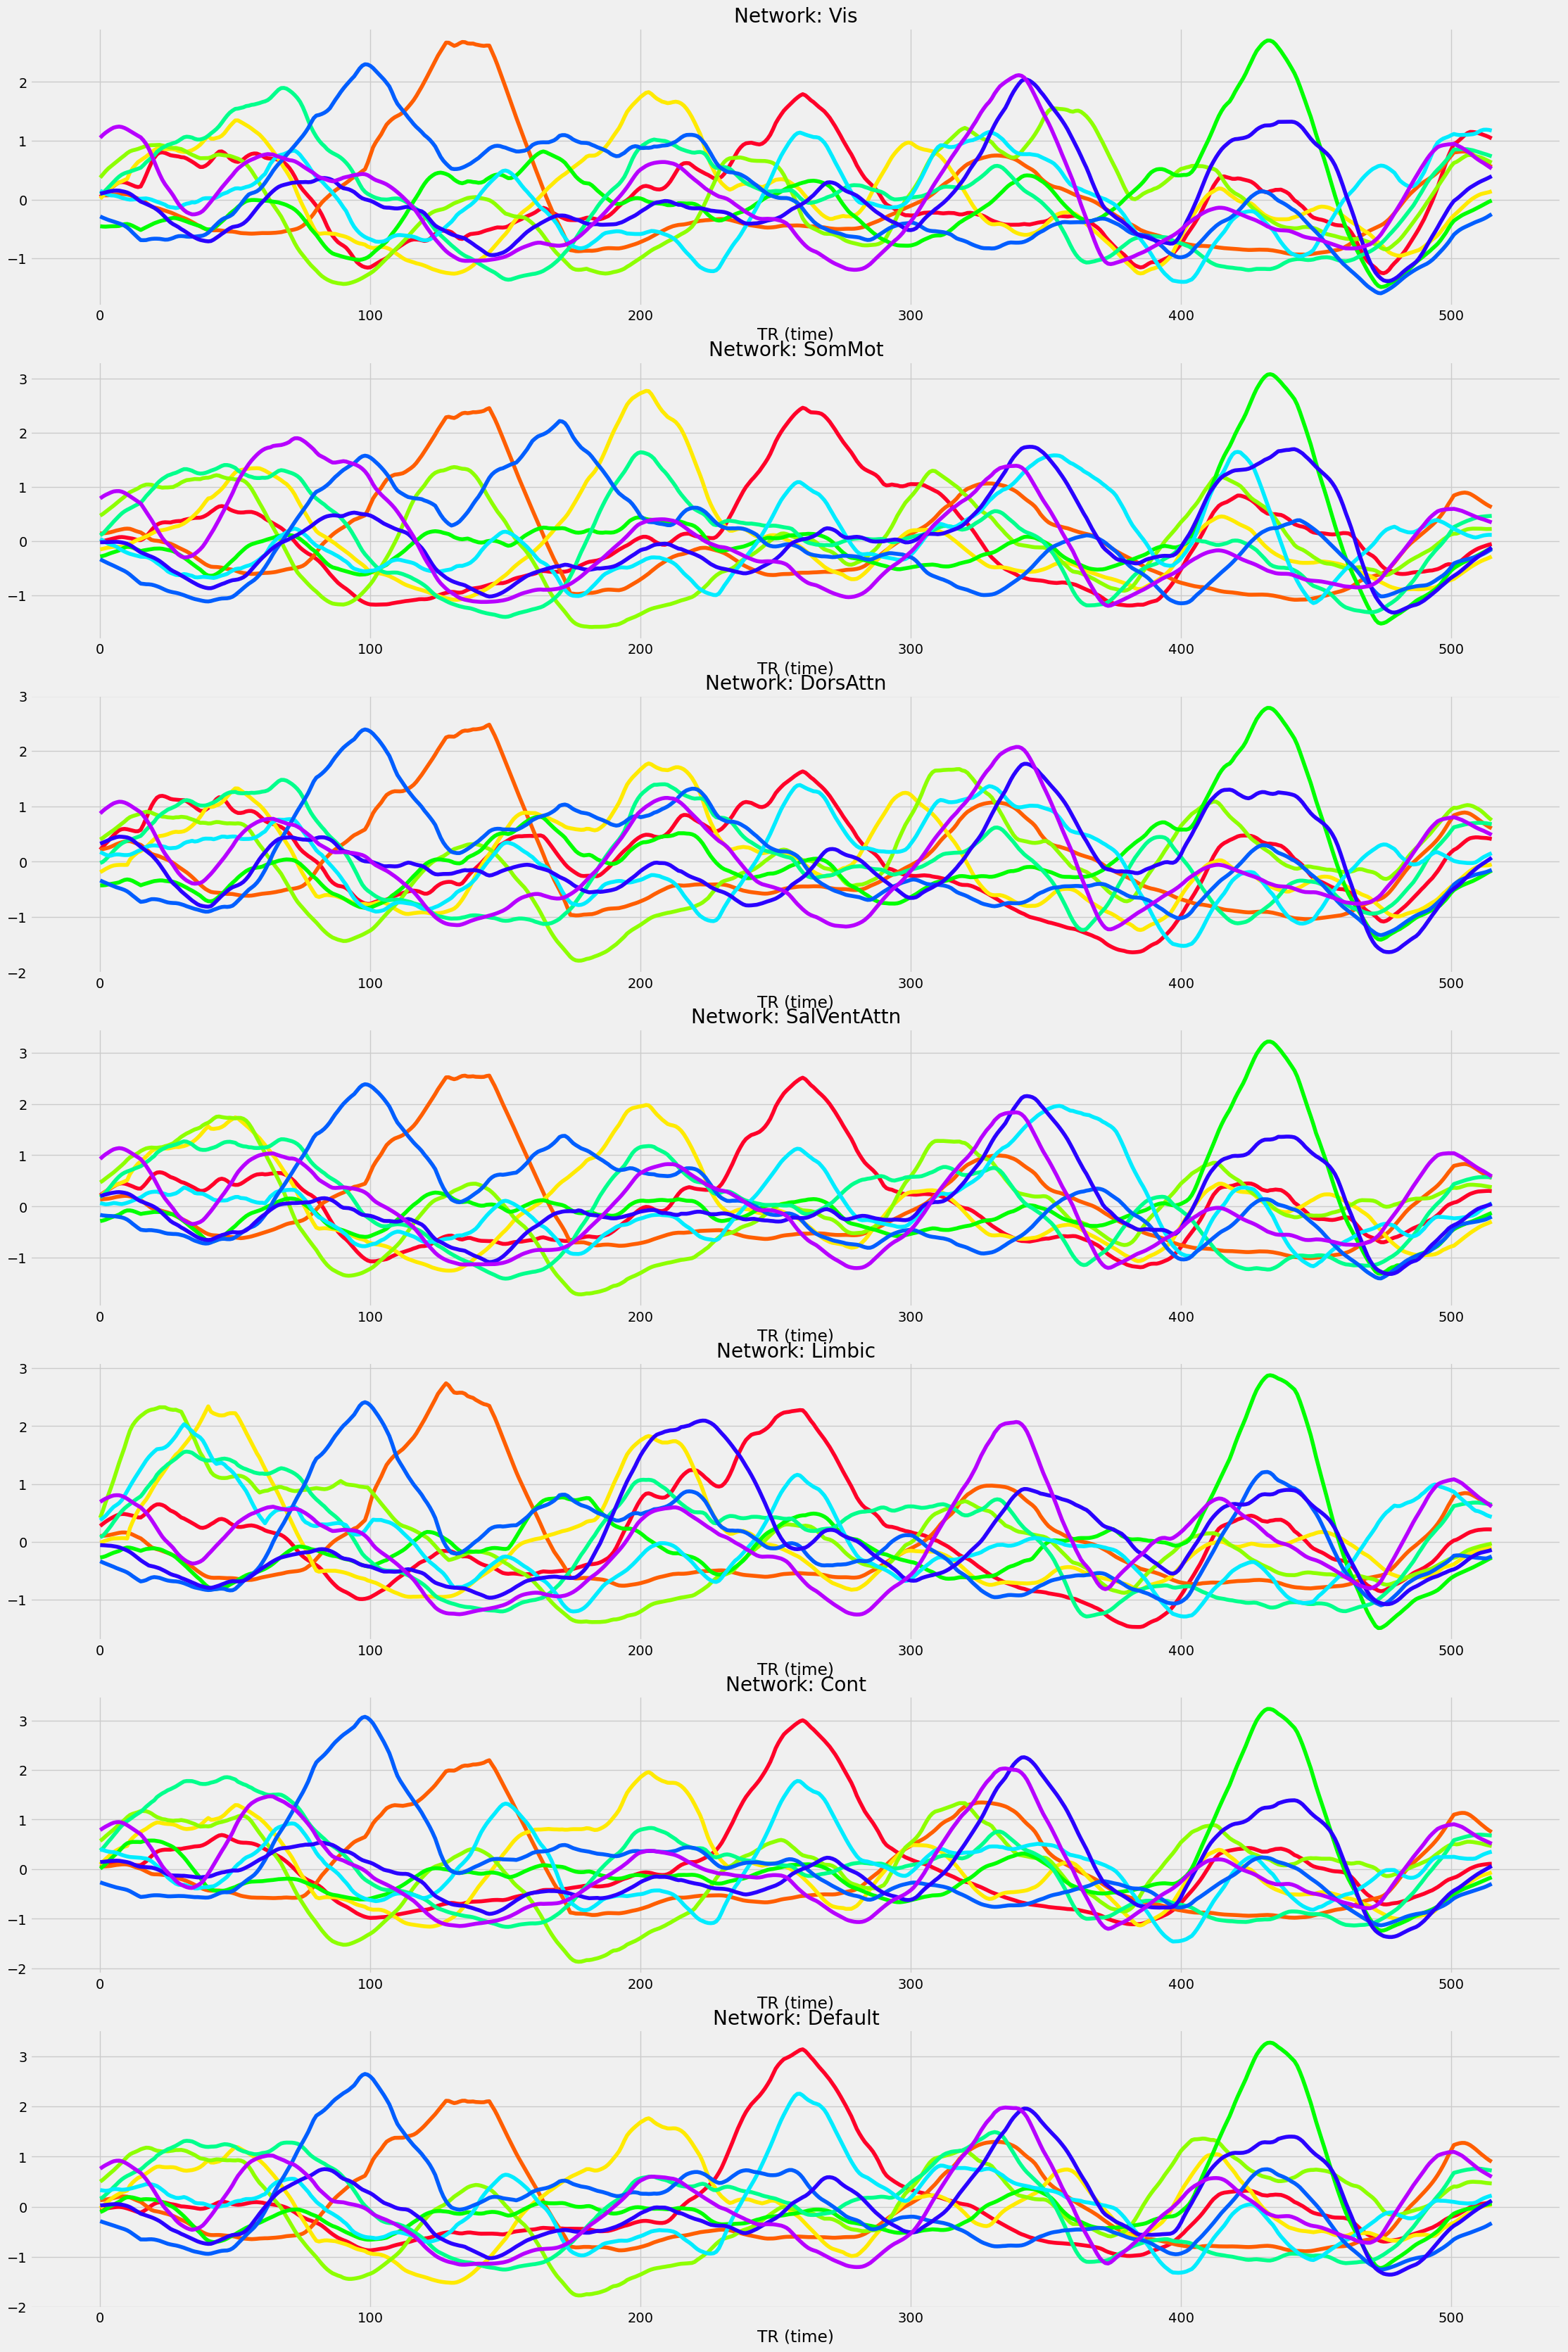

In [47]:
NUM_COLORS = len(subjects) - 20
fig, ax = plt.subplots(7,1, figsize=(25,40))
cm = plt.get_cmap('gist_rainbow')
for i in range(len(networks)):
    ax[i].set_prop_cycle(color=[cm(1.*k/NUM_COLORS) for k in range(NUM_COLORS)])
    for s in range(len(subjects)-20):
        tmp = indiv_metrics[s][i]
        tmp = low_pass(tmp, ks=30)
        ax[i].plot(tmp)
        ax[i].set_title('Network: {}'.format(networks[i]))
        ax[i].set_xlabel('TR (time)')
